# Programming the Longstaff-Schwartz algorithm for a Bermudan call option.


### Statement:


Program the Longstaff-Schwartz algorithm for a Bermudan Call option within a Black-Scholes model. This means a call option that can be exercised on the dates $k/N$, $k=0,\dots,N$. 

We'll use $r=0.04$, $\sigma=0.1$, $x_0=100$, and the strike $K=100$ with $N=10$ dates up to $T=1$, and the payoff $\phi_k(x) = e^{-r k/N}(x-K)_+$.


### Import :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.metrics import r2_score

### Parameters : 

In [2]:
np.random.seed(42)

x0 = 100    # initial price of the asset
r = 0.04    # interest rate
sigma = 0.1 # volatility
T = 1       # maturity
K=100       # strike
N = 1000    # number of time steps
#The asset will be me simulated every 0.01 units of time and the holder of the option will be able to exercise it every 0.1 units of time

number_of_paths = 100000 # number of paths to simulate

### Generation of trajectories


We start by generating `number_of_paths` asset trajectories following the Black-Scholes dynamics.


Time :  [0.    0.001 0.002 ... 0.998 0.999 1.   ]


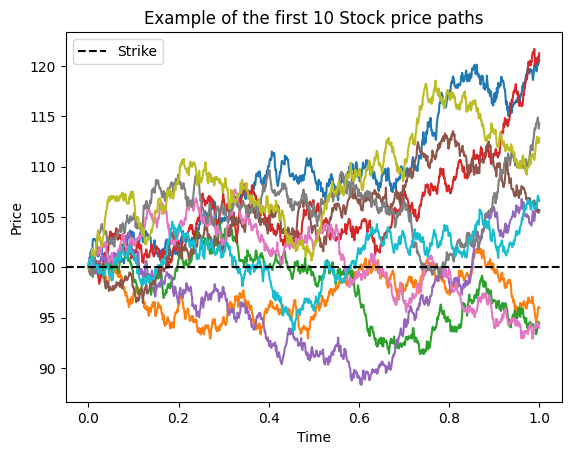

In [3]:
def generate_BS(x0, r, sigma, T, N, number_of_paths):
    dt = T/N
    time = np.linspace(0, T, N+1)

    dB = np.sqrt(dt) * np.random.randn(N, number_of_paths)
    brownian = np.zeros((N+1, number_of_paths))
    brownian[1:] = np.cumsum(dB, axis=0)

    t = time[:, np.newaxis]
    St = x0 * np.exp((r - 0.5*sigma**2)*t + sigma*brownian)

    return time, St.T

time, Xt = generate_BS(x0, r, sigma, T, N, number_of_paths)
for k in range(10):
    plt.plot(time, Xt[k])
print("Time : ", time)
plt.axhline(y=K, color='black', label='Strike', linestyle='--')
plt.title('Example of the first 10 Stock price paths')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


### Below is the curve of the associated payoffs


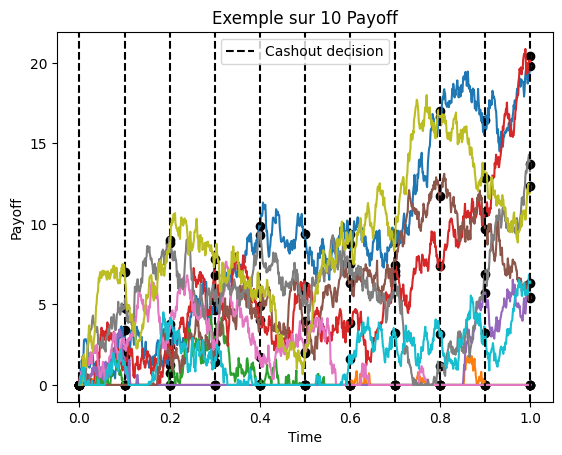

In [4]:
def payoff(x,t): #t = 0, 100, ... 1000
    t= t/N #then t = 0, 0.1, ... 1
    return np.maximum(x-K,0)*np.exp(-r*t)

# Payoff at all times
time_bis = (time*1000).astype(int)
payoff_to_plot = np.zeros((number_of_paths, len(time_bis)))
for i, t in enumerate(time_bis):
    payoff_to_plot[:, i] = payoff(Xt[:, t], t)

# Payoff at execution times
execution_time = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
payoff_time = np.zeros((number_of_paths, len(execution_time)))
for i, t in enumerate(execution_time):
    payoff_time[:, i] = payoff(Xt[:, t], t)

for k in range(10):
    plt.plot(time, payoff_to_plot[k])
    plt.axvline(x=execution_time[k]/N, color='black', linestyle='--')
    plt.scatter(time[::100], payoff_time[k], color='black')
plt.axvline(x=execution_time[-1]/N, color='black', linestyle='--', label='Cashout decision' )

plt.title('Exemple sur 10 Payoff')
plt.xlabel('Time')
plt.ylabel('Payoff')
plt.legend()
plt.show()


In [5]:
# lignes : payoff per trajectory
# colonnes : payoff at different exercices times
payoff_time.shape

(100000, 11)

We will try two regressions for the Longstaff-Schwartz algorithm:

$\phi_1(x,\theta) = \theta_0 + \theta_1x + \theta_2 x^2$

and

$\phi_2(x,\theta) = \theta_0 + \theta_1x + \theta_2 x^2 + \theta_3 (x-K)_+$


- We then apply the Longstaff-Schwartz algorithm:

$\tau_N = N$

$\tau_n = n \mathbb{I}_{Payoff(X_n) \geq \phi(X_n, \hat{\theta_n})} + \tau_{n+1} \mathbb{I}_{Payoff(X_n) < \phi(X_n, \hat{\theta_n})}$

with 

$\hat{\theta_n} = argmin_{theta} \mathbb{E} [Payoff(X_{\tau_{n+1}}) - \phi(X_n, \theta)^2]$

In [6]:
def phi(x, theta):
    return theta[0] + theta[1]*x + theta[2]*x**2

In [7]:
def longstaff_schwartz_1(X, time, r, T, N, K):
    tau = np.zeros((number_of_paths, len(execution_time))).astype(int) # tau will contain the optimal stopping times for each trajectory
    tau[:,-1] = 10 # Initialization of the last tau to 10
    thetas = np.zeros((len(execution_time)-1, 3))
    
    for i in range(len(execution_time)-2, -1, -1):
        index_to_sum = tau[:,i+1]
        payoffs = payoff_time[np.arange(number_of_paths), tau[:,i+1]]
        Xs = Xt[:, execution_time[i]] # Retrieving the values of X at time i
        theta_min = np.polyfit(Xs, payoffs, 2)[::-1] # See the documentation for polyfit; the order is reversed. (a, b, c) -> c + bx + ax^2
        thetas[i] = theta_min
        # theta_min[0] is the constant, theta_min[1] is the coefficient of x, theta_min[2] is the coefficient of x^2
        tau[:,i] = np.where(payoff_time[:,i] >= phi(Xs, theta_min), i, tau[:,i+1])

    return tau, thetas

tau, thetas = longstaff_schwartz_1(Xt, time, r, T, N, K)
print(tau)
print(tau.shape)

[[ 8  8  8 ...  8  9 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [ 9  9  9 ...  9  9 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
(100000, 11)


/tmp/ipykernel_1991/4223122275.py:10: RankWarning: Polyfit may be poorly conditioned
  theta_min = np.polyfit(Xs, payoffs, 2)[::-1] # See the documentation for polyfit; the order is reversed. (a, b, c) -> c + bx + ax^2


We have thus calculated the optimal stopping times at each moment. Therefore, we just need to deduce the average optimal decision strategy of cashing out or holding at the decision dates:


In [8]:
def stopping_times(tau):
    stopping_times = np.zeros(number_of_paths)
    for i in range(number_of_paths):
        for j in range(len(execution_time)):
            if tau[i,j] == j: # If tau[i,j] == j, then we have found the optimal stopping time for trajectory i
                stopping_times[i] = j
                break #We exit to save computation time
    return(stopping_times)
st_times = stopping_times(tau)
print(st_times)

[ 8. 10. 10. ...  9. 10. 10.]


We then deduce the payoff of each trajectory:


In [9]:
best_payoff = np.zeros(number_of_paths)
for i in range(number_of_paths):
    best_payoff[i] = payoff_time[i, int(st_times[i])]
print(best_payoff)

[17.01092515  0.          0.         ... 12.59769213  8.68107777
  0.50988625]


By calculating the average of these payoffs obtained with the average optimal strategy, we get the fair price of the Bermudan call option.


In [11]:
m = np.mean(best_payoff)
ic_size = 1.96 * np.sqrt(np.var(best_payoff, ddof=1) / number_of_paths) 
print(f"The value of the call with {number_of_paths} simulations is: {m:.4}, and the estimated variance is {np.var(best_payoff):.4}.")
print(f"The true value lies within the interval [{m-ic_size:.4}, {m+ic_size:.4}] with a probability of 0.95 (M = {number_of_paths}).")


The value of the call with 100000 simulations is: 5.926, and the estimated variance is 47.22.
The true value lies within the interval [5.883, 5.968] with a probability of 0.95 (M = 100000).


### Discussion on the regression $\phi_1$:


Let's plot the regression $\phi_1$ on the payoffs for the first step of the algorithm:


score =  770101.9955989618


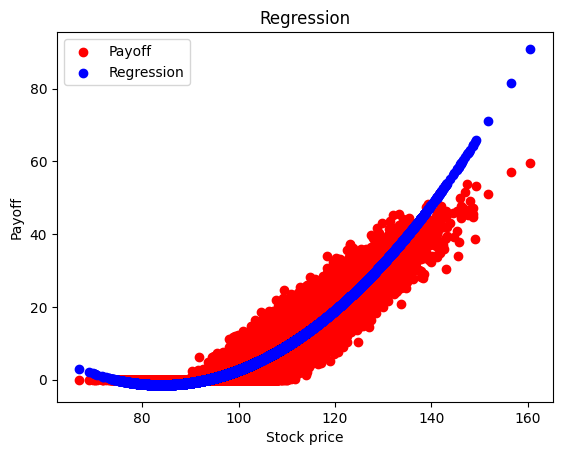

In [12]:
tau = np.zeros((number_of_paths, len(execution_time))).astype(int)
tau[:,-1] = 10

i=9
index_to_sum = tau[:,i+1]
payoffs = payoff_time[np.arange(number_of_paths), tau[:,i+1]]
Xs = Xt[:, execution_time[i]]
theta_min = np.polyfit(Xs, payoffs, 2)

print('score = ', np.sum((payoffs-Xs**2*theta_min[0]-Xs*theta_min[1]-theta_min[2])**2))
plt.scatter(Xs, payoffs, color='red', label='Payoff')
plt.scatter(Xs, phi(Xs, theta_min[::-1]), color='blue', label='Regression')
plt.title('Regression')
plt.xlabel('Stock price')
plt.ylabel('Payoff')
plt.legend()
plt.show()

We notice that the regression is good ITM (in the money) but poor OTM (out of the money).


One idea to improve the regression is to use $\phi_2$; the term $\theta_3(K-x)_+$ should capture the OTM (out of the money) portion of the payoffs.


# Algorithm with $\phi_2$


We solve the optimization problem for $\theta$ using OLS (ordinary least squares).

$Payoffs = \theta \hat{X}$ where $\hat{X} = [1, X, X^2, (X-K)_+]$ (concatenation of the vectors)


In [13]:
'''
def phi_v2(x, theta):
    return theta[0] + theta[1]*x + theta[2]*x**2 + theta[3]*np.maximum(K-x,0)
'''
def fit_theta(Xs, payoffs):
    Xs = Xs.reshape(-1,1)
    X = np.concatenate((Xs, Xs**2, np.maximum(Xs-K,0)), axis=1)
    
    Y = payoffs
    
    
    model = lm.LinearRegression(fit_intercept=True)
    model.fit(X,Y)
    theta = np.append(model.intercept_, model.coef_)

    return model

Let's plot the regression for the first step of the algorithm.


score =  674235.4790910265


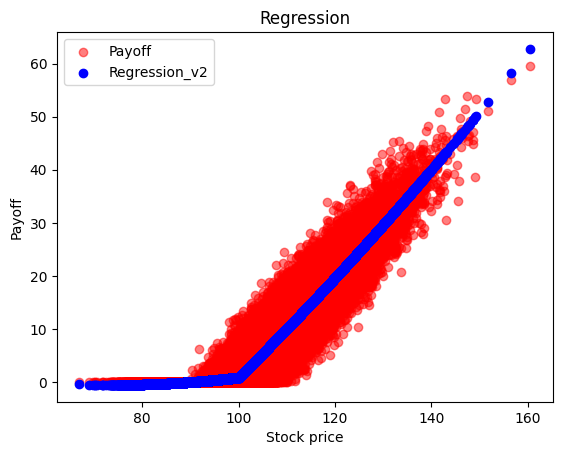

In [15]:
tau = np.zeros((number_of_paths, len(execution_time))).astype(int)
tau[:,-1] = 10

i=9
index_to_sum = tau[:,i+1]
payoffs = payoff_time[np.arange(number_of_paths), tau[:,i+1]]
Xs = Xt[:, execution_time[i]]

model = fit_theta(Xs, payoffs)

Xs = Xs.reshape(-1,1)
X = np.concatenate((Xs, Xs**2, np.maximum(Xs-K,0)), axis=1)

plt.scatter(Xs, payoffs, color='red', alpha=0.5, label='Payoff')
#plt.scatter(Xs, phi_v2(Xs, theta_min), color='black', label='Regression' )
plt.scatter(Xs, model.predict(X), color='blue', label='Regression_v2')

print('score = ',  str(np.sum((payoffs-model.predict(X))**2)))
plt.title('Regression')
plt.xlabel('Stock price')
plt.ylabel('Payoff')
plt.legend()
plt.show()

We see that the regression captures much more information for the OTM (out of the money) part.

Similarly, the score/MSE (mean squared error) is almost halved compared to the previous regression.


In [17]:
def longstaff_schwartz_v2(X, time, r, T, N, K):
    tau = np.zeros((number_of_paths, len(execution_time))).astype(int)
    tau[:,-1] = 10
    thetas = np.zeros((len(execution_time)-1, 4))
    for i in range(len(execution_time)-2, -1, -1):
        
        index_to_sum = tau[:,i+1]
        payoffs = payoff_time[np.arange(number_of_paths), tau[:,i+1]]
        Xs = Xt[:, execution_time[i]]

        model = fit_theta(Xs, payoffs)
        theta_min = np.append(model.intercept_, model.coef_)
        thetas[i] = theta_min

        Xs = Xs.reshape(-1,1)
        X = np.concatenate((Xs, Xs**2, np.maximum(Xs-K,0)), axis=1)

        tau[:,i] = np.where(payoff_time[:,i] >= model.predict(X), i, tau[:,i+1])
        
    return tau, thetas

tau_v2, thetas_v2 = longstaff_schwartz_v2(Xt, time, r, T, N, K)
print(tau_v2)

[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


We have thus calculated the optimal stopping times at each moment. Therefore, we just need to deduce the average optimal decision strategy of cashing out or holding at the decision dates:


In [18]:
st_times_v2 = stopping_times(tau_v2)
print(st_times_v2)

[10. 10. 10. ... 10. 10. 10.]


We then deduce the payoff of each trajectory:


In [19]:
best_payoff_v2 = np.zeros(number_of_paths)
for i in range(number_of_paths):
    best_payoff_v2[i] = payoff_time[i, int(st_times_v2[i])]
print(best_payoff_v2)

[19.81413547  0.          0.         ... 16.64277241  8.68107777
  0.50988625]


In [20]:
m = np.mean(best_payoff_v2)
ic_size = 1.96 * np.sqrt(np.var(best_payoff_v2, ddof=1) / number_of_paths)
print(f"The value of the call with {number_of_paths} simulations is: {m:.4}, and the estimated variance is {np.var(best_payoff_v2):.4}.")
print(f"The true value lies within the interval [{m-ic_size:.4}, {m+ic_size:.4}] with a probability of 0.95 (M = {number_of_paths}).")


The value of the put with 100000 simulations is: 6.141, and the estimated variance is 55.71.
The true value lies within the interval [6.094, 6.187] with a probability of 0.95 (M = 100000).


### Brief comparison of prices based on the regression:


For $\phi_1(x,\theta) = \theta_0 + \theta_1x + \theta_2 x^2$ :


In [21]:
m = np.mean(best_payoff)
ic_size = 1.96 * np.sqrt(np.var(best_payoff, ddof=1) / number_of_paths) 
print(f"The value of the call with {number_of_paths} simulations is: {m:.4}, and the estimated variance is {np.var(best_payoff):.4}.")
print(f"The true value lies within the interval [{m-ic_size:.4}, {m+ic_size:.4}] with a probability of 0.95 (M = {number_of_paths}).")


The value of the put with 100000 simulations is: 5.926, and the estimated variance is 47.22.
The true value lies within the interval [5.883, 5.968] with a probability of 0.95 (M = 100000).


For $\phi_2(x,\theta) = \theta_0 + \theta_1x + \theta_2 x^2 + \theta_3 (x-K)_+$ :


In [22]:
m = np.mean(best_payoff_v2)
ic_size = 1.96 * np.sqrt(np.var(best_payoff_v2, ddof=1) / number_of_paths)
print(f"The value of the call with {number_of_paths} simulations is: {m:.4}, and the estimated variance is {np.var(best_payoff_v2):.4}.")
print(f"The true value lies within the interval [{m-ic_size:.4}, {m+ic_size:.4}] with a probability of 0.95 (M = {number_of_paths}).")


The value of the put with 100000 simulations is: 6.141, and the estimated variance is 55.71.
The true value lies within the interval [6.094, 6.187] with a probability of 0.95 (M = 100000).


The order of magnitude of the prices found is similar. The order of magnitude of the values obtained (on the order of the unit of currency for $x_0=K=100$) seems reasonable.

However, we notice that the two confidence intervals from Monte Carlo are disjoint.

We also observe that the better regressor $\phi_2$ gives a higher fair price than the regressor $\phi_1$.


In [29]:
from scipy.stats import norm

def priceBS(x0, r, sigma, T, K):
    d1 = (np.log(x0/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return x0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
print('Black Scholes Price of European Call = ', priceBS(x0, r, sigma, T, K))

Black Scholes Price of European Call =  6.178461553404809
